### Nested Time Series

In [2]:
suppressMessages(library(tidyverse))
suppressMessages(library(tsibble))
suppressMessages(library(fable))
suppressMessages(library(tsibble))
suppressMessages(library(fabletools))
suppressMessages(library(feasts))
suppressMessages(library(lubridate))
suppressMessages(library(scales))
suppressMessages(library(fpp3))
suppressMessages(library(gridExtra))

In [ ]:
tsibble::tourism %>% head()

In [ ]:
tourism <- tsibble::tourism |>
  mutate(State = recode(State,
    `New South Wales` = "NSW",
    `Northern Territory` = "NT",
    `Queensland` = "QLD",
    `South Australia` = "SA",
    `Tasmania` = "TAS",
    `Victoria` = "VIC",
    `Western Australia` = "WA"
  ))

tourism_hts <- tourism |>
aggregate_key(State / Region, Trips = sum(Trips))

tourism_hts %>% head()

In [ ]:
tourism_hts %>% filter(State == 'WA', !is_aggregated(Region)) %>% head(10)

In [ ]:
tourism_hts |>
  filter(is_aggregated(Region)) |>
  autoplot(Trips) +
  labs(y = "Trips ('000)",
       title = "Australian tourism: national and states") +
  facet_wrap(vars(State), scales = "free_y", ncol = 3) +
  theme(legend.position = "none")

In [ ]:
tourism_hts |>
  autoplot(Trips) +
  labs(y = "Trips ('000)",
       title = "Australian tourism: national, states, and regions") +
  facet_wrap(vars(State), scales = "free_y", ncol = 3) +
  theme(legend.position = "none")

In [ ]:
tourism_hts |>
  filter(State == "NT" | State == "QLD" |
         State == "TAS" | State == "VIC", is_aggregated(Region)) |>
  select(-Region) |>
  mutate(State = factor(State, levels=c("QLD","VIC","NT","TAS"))) |>
  gg_season(Trips) +
  facet_wrap(vars(State), nrow = 2, scales = "free_y")+
  labs(y = "Trips ('000)")

### Grouped Data

In [ ]:
prison <- readr::read_csv("https://OTexts.com/fpp3/extrafiles/prison_population.csv") |>
  mutate(Quarter = yearquarter(Date)) |>
  select(-Date)  |>
  as_tsibble(key = c(Gender, Legal, State, Indigenous),
             index = Quarter) |>
  relocate(Quarter)

In [ ]:
prison %>% head()

In [ ]:
prisoners_gts <- prison %>%
    aggregate_key(Gender * Legal * State, Count = sum(Count)/1e3)

In [ ]:
prisoners_gts %>% head()

In [ ]:
prisoners_gts |>
  filter(is_aggregated(Gender), is_aggregated(Legal),
         is_aggregated(State)) |>
  autoplot(Count) +
  labs(y = "Number of prisoners ('000)")

In [ ]:
options(repr.plot.width=15, repr.plot.height=8)

prisoners_gts |>
  filter(!is_aggregated(Gender), is_aggregated(Legal),
         is_aggregated(State)) |>
  mutate(Gender = as.character(Gender)) |>
  ggplot(aes(x = Quarter, y = Count)) +
  stat_summary(fun = sum, geom = "line") +
  labs(title = "Prison population by ender",
       y = "Number of prisoners ('000)") +
  facet_wrap(~ as.character(Gender), nrow = 1) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

In [ ]:
options(repr.plot.width=15, repr.plot.height=8)

prisoners_gts |>
  filter(!is_aggregated(Gender), !is_aggregated(Legal),
         !is_aggregated(State)) |>
  mutate(Gender = as.character(Gender)) |>
  ggplot(aes(x = Quarter, y = Count,
             group = Gender, colour=Gender)) +
  stat_summary(fun = sum, geom = "line") +
  labs(title = "Prison population by state and gender",
       y = "Number of prisoners ('000)") +
  facet_wrap(~ as.character(State),
             nrow = 1) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

In [ ]:
options(repr.plot.width=15, repr.plot.height=8)

prisoners_gts |>
  filter(!is_aggregated(Gender), !is_aggregated(Legal),
         is_aggregated(State)) |>
  mutate(Gender = as.character(Gender)) |>
  ggplot(aes(x = Quarter, y = Count,
             group = Gender, colour=Gender)) +
  stat_summary(fun = sum, geom = "line") +
  labs(title = "Prison population by state and legal",
       y = "Number of prisoners ('000)") +
  facet_wrap(~ as.character(Legal), nrow = 1) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

### Crossed Data Example with Tourism

In [ ]:
tourism_full <- tourism |>
  aggregate_key((State/Region) * Purpose, Trips = sum(Trips))

tourism_full %>% head()

In [ ]:
tourism_full |>
filter(!is_aggregated(State), is_aggregated(Region), is_aggregated(Purpose)) |>
mutate(State = as.character(State)) |>
ggplot(aes(x=Quarter, y=Trips, group=State, colour=State)) +
stat_summary(fun = sum, geom = "line") +
facet_wrap(as.character(Purpose) ~ ., scales = "free_y", ncol = 1)  + 
labs(y = "Trips ('000)", title = "Australian tourism: State and Purpose")

### Bottom-ups Forecast for Tourism
State to National Forecasts

In [ ]:
tourism_states <- tourism |>
  aggregate_key(State, Trips = sum(Trips))

tourism_states %>% head()

In [ ]:
tourism_states |> count(State)

In [ ]:
tourism_states |>
  filter(!is_aggregated(State)) |>
  autoplot(Trips) +
  labs(y = "Trips ('000)",
       title = "Australian tourism: national and states") +
  facet_wrap(vars(State), scales = "free_y", ncol = 2) +
  theme(legend.position = "none")

Could produce the forecasts and simply sum to get the aggregates:

In [ ]:
fcasts_state <- tourism_states |>
  filter(!is_aggregated(State)) |>
  model(ets = ETS(Trips)) |>
  forecast()

# Sum bottom-level forecasts to get top-level forecasts
fcasts_national <- fcasts_state |>
  summarise(value = sum(Trips), .mean = mean(value))

In [ ]:
fcasts_state %>% autoplot(tourism_states)  +
  theme(legend.position = "none")

In [ ]:
fcasts_national %>% autoplot()

Or use reconciliation which is going to be more generalized:

In [ ]:
fcast_both <- tourism_states |>
  model(ets = ETS(Trips)) |>
  reconcile(bu = bottom_up(ets)) |>
  forecast()

fcast_both %>% filter(is_aggregated(State)) %>% autoplot(tourism_states) + facet_wrap(. ~ .model, ncol=1)

### Comparing Top-down Methods

In [ ]:
tourism_states |>
  model(ets = ETS(Trips)) |>
  reconcile(td = top_down(ets, method = 'average_proportions')) |>
  forecast() |>
  filter(!is_aggregated(State), .model == 'td') |>
  autoplot(tourism_states)  +
  theme(legend.position = "none") +
  labs(title='Average Historical Proportions')

In [ ]:
tourism_states |>
  model(ets = ETS(Trips)) |>
  reconcile(td = top_down(ets, method = 'proportion_averages')) |>
  forecast() |>
  filter(!is_aggregated(State), .model == 'td') |>
  autoplot(tourism_states)  +
  theme(legend.position = "none") +
  labs(title='Proportions of Historical Averages')

In [ ]:
tourism_states |>
  model(ets = ETS(Trips)) |>
  reconcile(td = top_down(ets, method = 'forecast_proportions')) |>
  forecast() |>
  filter(!is_aggregated(State), .model == 'td') |>
  autoplot(tourism_states)  +
  theme(legend.position = "none") +
  labs(title='Proportions of Forecasts')

### Comparing Reconciliations with Tourism Data
Now four level (Aggregate, State, Region, Purpose)

In [ ]:
tourism_full <- tourism |>
  aggregate_key((State/Region) * Purpose, Trips = sum(Trips))

fit <- tourism_full |>
  filter(year(Quarter) <= 2015) |>
  model(base = ETS(Trips)) |>
  reconcile(
    bu = bottom_up(base),
    ols = min_trace(base, method = "ols"),
    mint = min_trace(base, method = "mint_shrink")
  )

fc <- fit |> forecast(h = "2 years")

In [ ]:
fit %>% nrow()

In [ ]:
fc |>
  filter(is_aggregated(Region), is_aggregated(Purpose)) |>
  autoplot(
    tourism_full |> filter(year(Quarter) >= 2011),
    level = NULL
  ) +
  labs(y = "Trips ('000)", title='State Forecasts') +
  theme(legend.position = "none") +
  facet_wrap(vars(State), scales = "free_y")

In [ ]:
fc |>
  filter(is_aggregated(State), !is_aggregated(Purpose)) |>
  autoplot(
    tourism_full |> filter(year(Quarter) >= 2011),
    level = NULL
  ) +
  labs(y = "Trips ('000)", title='Purpose') +
  facet_wrap(vars(Purpose), scales = "free_y")

In [ ]:
# aggregate state, purpose
fc |>
  filter(is_aggregated(State), is_aggregated(Purpose)) |>
  accuracy(
    data = tourism_full,
    measures = list(rmse = RMSE, mase = MASE)
  ) |>
  group_by(.model) |>
  summarise(rmse = mean(rmse), mase = mean(mase))

In [ ]:
# across all levels
fc |>
  accuracy(
    data = tourism_full,
    measures = list(rmse = RMSE, mase = MASE)
  ) |>
  group_by(.model) |>
  summarise(rmse = mean(rmse), mase = mean(mase))

### Reconciliation on Prisoner Data

In [ ]:
prison_sg <- prison %>%
    aggregate_key(Gender * State, Count = sum(Count)/1e3)

prison_sg %>% head()

In [ ]:
prison_sg |>
  filter(is_aggregated(Gender), is_aggregated(State)) |>
  autoplot(Count) +
  labs(y = "Number of prisoners ('000)")

In [ ]:
fit_sg <- prison_sg |>
  filter(year(Quarter) <= 2014) |>
  model(base = ETS(Count)) |>
  reconcile(
    bottom_up = bottom_up(base),
    MinT = min_trace(base, method = "mint_shrink")
  )
 
fc <- fit_sg |> forecast(h = 8)

fc |>
  filter(is_aggregated(State), is_aggregated(Gender)) |>
  autoplot(prison_sg, alpha = 0.7, level = 90) +
  labs(y = "Number of prisoners ('000)",
       title = "Australian prison population (total)")

In [ ]:
fc |>
  filter(
    !is_aggregated(State), is_aggregated(Gender)
  ) |>
  autoplot(
    prison_sg |> filter(year(Quarter) >= 2010),
    alpha = 0.7, level = 90
  ) +
  labs(title = "Prison population (by state)",
       y = "Number of prisoners ('000)") +
  facet_wrap(vars(State), scales = "free_y", ncol = 4) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

In [ ]:
fc |>
  filter(is_aggregated(State), is_aggregated(Gender)) |>
  accuracy(data = prison_sg,
           measures = list(mase = MASE,
                           ss = skill_score(CRPS)
                           )
           ) |>
  group_by(.model) |>
  summarise(mase = mean(mase), sspc = mean(ss) * 100)

### Case-Shiller Home Sales Pair Counts

In [3]:
sp <- readxl::read_excel('data/cs_salespairs.xls', skip=1)
sp <- sp[complete.cases(sp), ]
sp %>% head()

YEAR,MONTH,PHXR,LXXR,SDXR,SFXR,DNXR,WDXR,MIXR,TPXR,⋯,MNXR,CRXR,LVXR,NYXR,CEXR,POXR,DAXR,SEXR,CSXR,CS20R
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2000,1,4724,9971,2695,4385,3529,4366,7224,3447,⋯,3765,1494,1437,8938,1708,2009,119,2665,48862,76273
2000,2,4776,9384,2554,4113,3239,4013,7107,3204,⋯,3251,1426,1393,8352,1496,1887,153,2490,45328,70994
2000,3,5395,9908,2899,4291,3451,3964,6839,3074,⋯,2710,1499,1514,8378,1577,2016,209,2892,46403,72795
2000,4,4277,11281,3386,4973,3125,4684,7871,3897,⋯,2753,1837,1788,7836,2004,2326,301,3606,50872,79561
2000,5,4540,12944,3796,5644,3277,5960,9060,4666,⋯,3179,2124,2078,8370,2577,2719,390,4057,58826,92584
2000,6,4737,13459,3838,5867,3791,7005,9519,4879,⋯,4033,2261,2192,9858,3053,3040,477,4232,65095,102644


In [4]:
city_sp <- sp %>% select(-CSXR, -CS20R)
city_sp %>% head()

YEAR,MONTH,PHXR,LXXR,SDXR,SFXR,DNXR,WDXR,MIXR,TPXR,⋯,BOXR,DEXR,MNXR,CRXR,LVXR,NYXR,CEXR,POXR,DAXR,SEXR
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2000,1,4724,9971,2695,4385,3529,4366,7224,3447,⋯,2872,3385,3765,1494,1437,8938,1708,2009,119,2665
2000,2,4776,9384,2554,4113,3239,4013,7107,3204,⋯,2506,3225,3251,1426,1393,8352,1496,1887,153,2490
2000,3,5395,9908,2899,4291,3451,3964,6839,3074,⋯,2469,3272,2710,1499,1514,8378,1577,2016,209,2892
2000,4,4277,11281,3386,4973,3125,4684,7871,3897,⋯,2744,3392,2753,1837,1788,7836,2004,2326,301,3606
2000,5,4540,12944,3796,5644,3277,5960,9060,4666,⋯,3298,4330,3179,2124,2078,8370,2577,2719,390,4057
2000,6,4737,13459,3838,5867,3791,7005,9519,4879,⋯,4135,4944,4033,2261,2192,9858,3053,3040,477,4232


In [5]:
sales_ts <- city_sp %>% 
pivot_longer(cols = 3:22, names_to = 'City', values_to = 'Sales') %>%
mutate(Month = yearmonth(as.Date(paste(YEAR,MONTH,1,sep='-')))) %>%
select(-YEAR, -MONTH) %>%
as_tsibble(index=Month, key=City) %>%
aggregate_key(City, Sales = sum(Sales))

sales_ts %>% head()


Month,City,Sales
<mth>,<chr*>,<dbl>
2000 Jan,<aggregated>,76273
2000 Feb,<aggregated>,70994
2000 Mar,<aggregated>,72795
2000 Apr,<aggregated>,79561
2000 May,<aggregated>,92584
2000 Jun,<aggregated>,102644


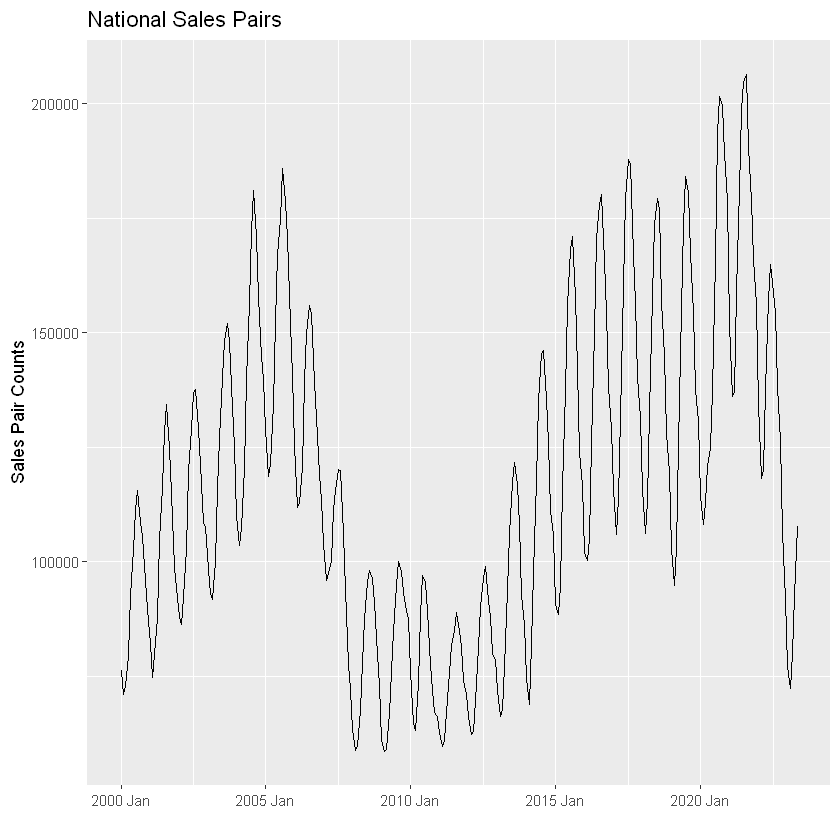

In [6]:
sales_ts %>%
filter(is_aggregated(City)) %>%
autoplot(Sales) +
labs(title='National Sales Pairs', x='', y='Sales Pair Counts')

Warning message:
"Removed 1 row containing missing values (`geom_line()`)."


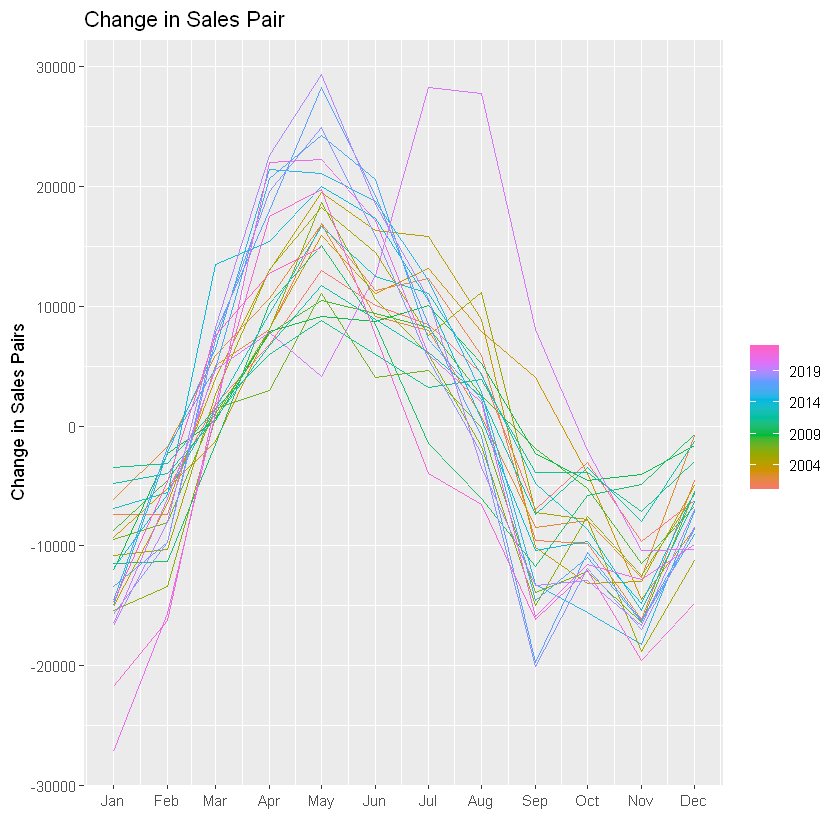

In [8]:
sales_ts %>%
filter(is_aggregated(City)) %>%
gg_season(difference(Sales)) +
labs(title = 'Change in Sales Pair', x='', y='Change in Sales Pairs')

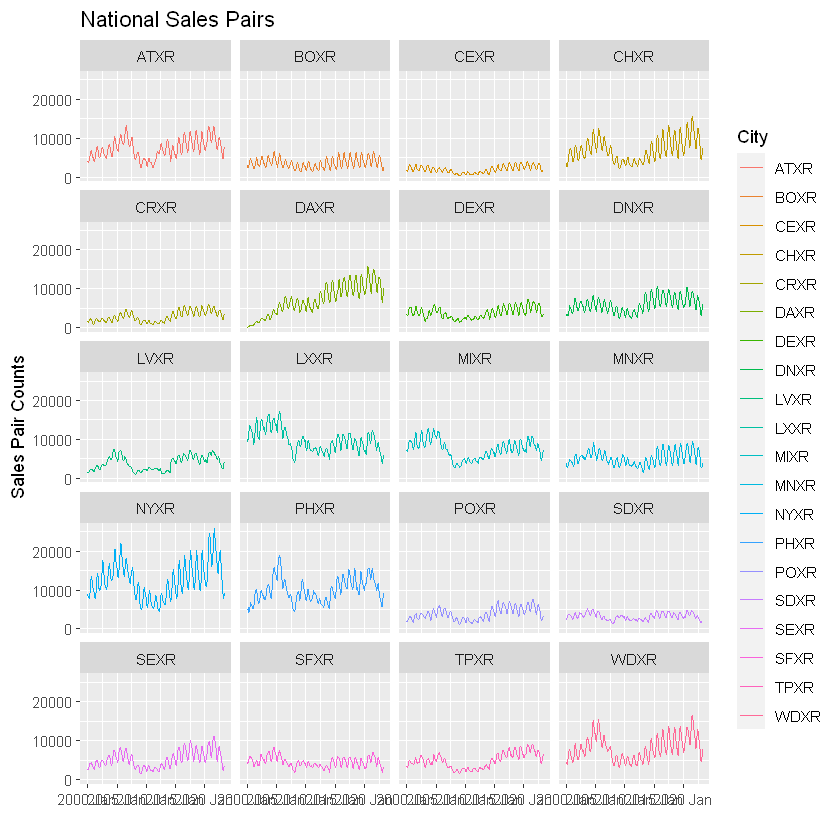

In [10]:
sales_ts %>%
filter(!is_aggregated(City)) %>%
autoplot(Sales) +
labs(title='National Sales Pairs', x='', y='Sales Pair Counts') +
facet_wrap(. ~ City,nrow = 5, ncol = 4)

#### Split to Training and test

In [11]:
sp_training <- sales_ts %>% filter_index(. ~ '2021 Dec')
sp_test <- sales_ts %>% filter_index('2022 Jan' ~ .)

In [12]:
sp_models <- sp_training %>%
model('ETS' = ETS(Sales), 'ARIMA' = ARIMA(Sales)) %>%
reconcile(bu = bottom_up(ARIMA), MinT = min_trace(ARIMA, method = "mint_shrink"))

Warning message in sqrt(diag(best$var.coef)):
"NaNs produced"


In [13]:
sp_models %>%
head()

City,ETS,ARIMA,bu,MinT
<chr*>,<model>,<model>,<model>,<model>
ATXR,"<ETS(M,Ad,M)>","<ARIMA(1,0,2)(0,1,1)[12]>","<ARIMA(1,0,2)(0,1,1)[12]>","<ARIMA(1,0,2)(0,1,1)[12]>"
BOXR,"<ETS(M,Ad,M)>","<ARIMA(1,0,2)(1,1,2)[12]>","<ARIMA(1,0,2)(1,1,2)[12]>","<ARIMA(1,0,2)(1,1,2)[12]>"
CEXR,"<ETS(M,N,M)>","<ARIMA(0,1,5)(0,1,1)[12]>","<ARIMA(0,1,5)(0,1,1)[12]>","<ARIMA(0,1,5)(0,1,1)[12]>"
CHXR,"<ETS(M,Ad,M)>","<ARIMA(2,1,3)(0,1,1)[12]>","<ARIMA(2,1,3)(0,1,1)[12]>","<ARIMA(2,1,3)(0,1,1)[12]>"
CRXR,"<ETS(M,Ad,M)>","<ARIMA(1,0,2)(1,1,2)[12]>","<ARIMA(1,0,2)(1,1,2)[12]>","<ARIMA(1,0,2)(1,1,2)[12]>"
DAXR,"<ETS(M,Ad,M)>","<ARIMA(2,0,3)(0,1,1)[12] w/ drift>","<ARIMA(2,0,3)(0,1,1)[12] w/ drift>","<ARIMA(2,0,3)(0,1,1)[12] w/ drift>"


#### Training Accuracy

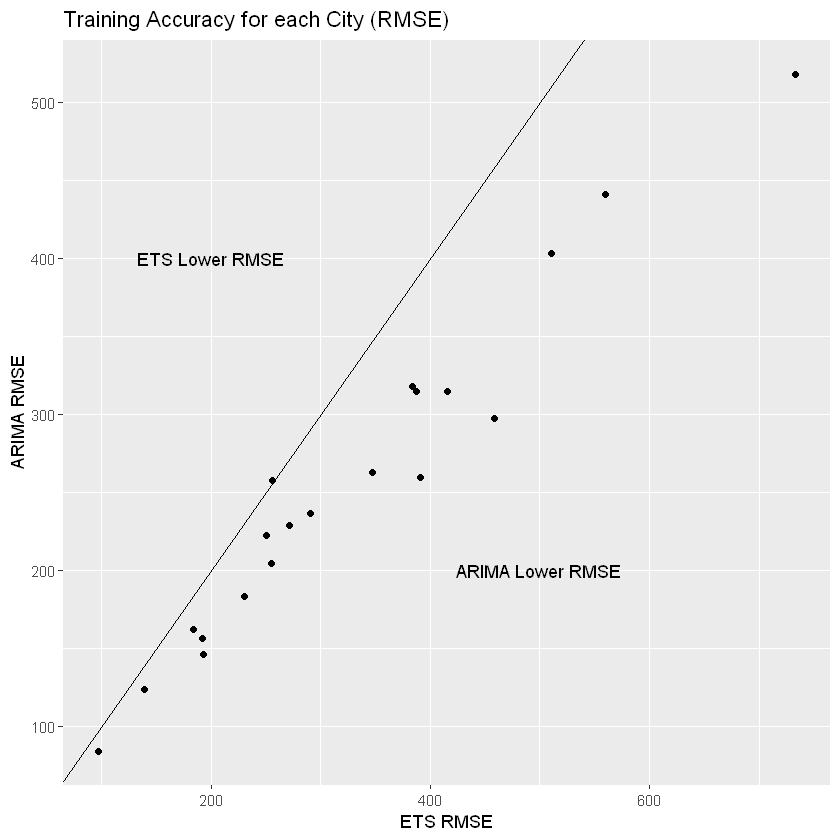

In [14]:
sp_models %>%
select(-bu, -MinT) %>%
filter(!is_aggregated(City)) %>%
accuracy() %>% 
select(City, .model, RMSE) %>%
rename(Model = .model) %>%
ungroup() %>%
pivot_wider(names_from = Model, values_from = RMSE) %>%
ggplot(aes(x=ETS, y=ARIMA)) + geom_point() + geom_abline(intercept = 0, slope=1) +
annotate('text', x=200, y=400, label='ETS Lower RMSE') +
annotate('text', x=500, y=200, label='ARIMA Lower RMSE') +
labs(title='Training Accuracy for each City (RMSE)', x='ETS RMSE', y='ARIMA RMSE')


In [15]:
sp_models %>%
select(-bu, -MinT) %>%
accuracy() %>% 
filter(is_aggregated(City)) %>%
select(City, .model, RMSE)

City,.model,RMSE
<chr*>,<chr>,<dbl>
<aggregated>,ETS,4397.115
<aggregated>,ARIMA,3469.482


#### Test Accuracy

In [16]:
sp_forecasts <- sp_models %>%
forecast(sp_test)

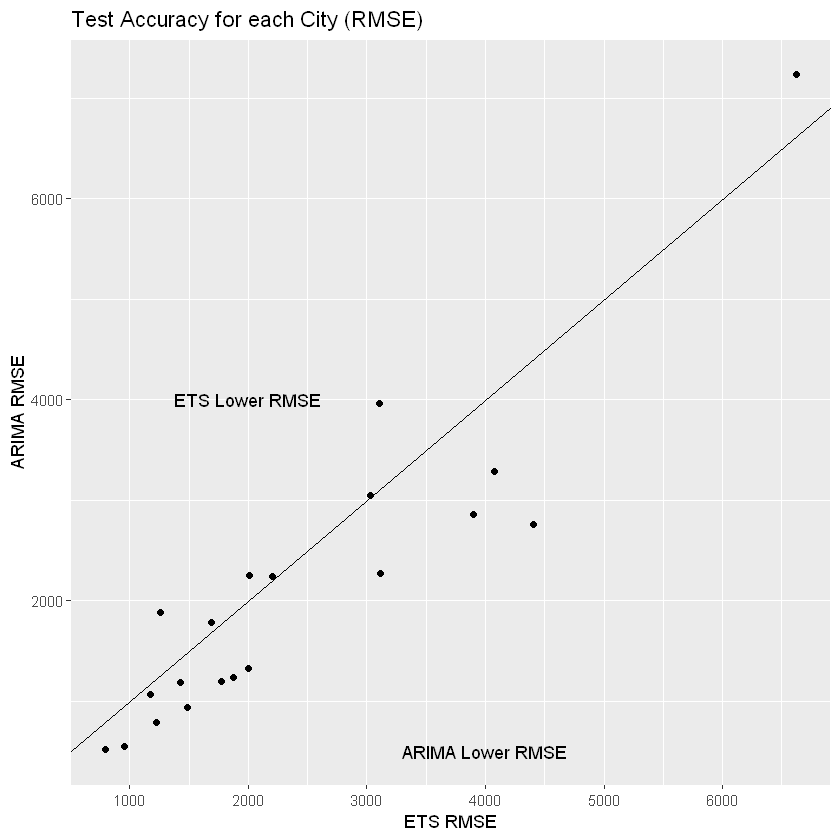

In [17]:
sp_forecasts %>%
accuracy(sp_test) %>% 
filter(!is_aggregated(City)) %>%
select(City, .model, RMSE) %>%
rename(Model = .model) %>%
ungroup() %>%
pivot_wider(names_from = Model, values_from = RMSE) %>%
ggplot(aes(x=ETS, y=ARIMA)) + geom_point() + geom_abline(intercept = 0, slope=1) +
annotate('text', x=2000, y=4000, label='ETS Lower RMSE') +
annotate('text', x=4000, y=500, label='ARIMA Lower RMSE') +
labs(title='Test Accuracy for each City (RMSE)', x='ETS RMSE', y='ARIMA RMSE')

In [18]:
sp_forecasts %>%
accuracy(sp_test) %>% 
filter(is_aggregated(City)) %>%
select(City, .model, RMSE)

City,.model,RMSE
<chr*>,<chr>,<dbl>
<aggregated>,ARIMA,29870.53
<aggregated>,ETS,50492.67
<aggregated>,MinT,39564.81
<aggregated>,bu,41739.63


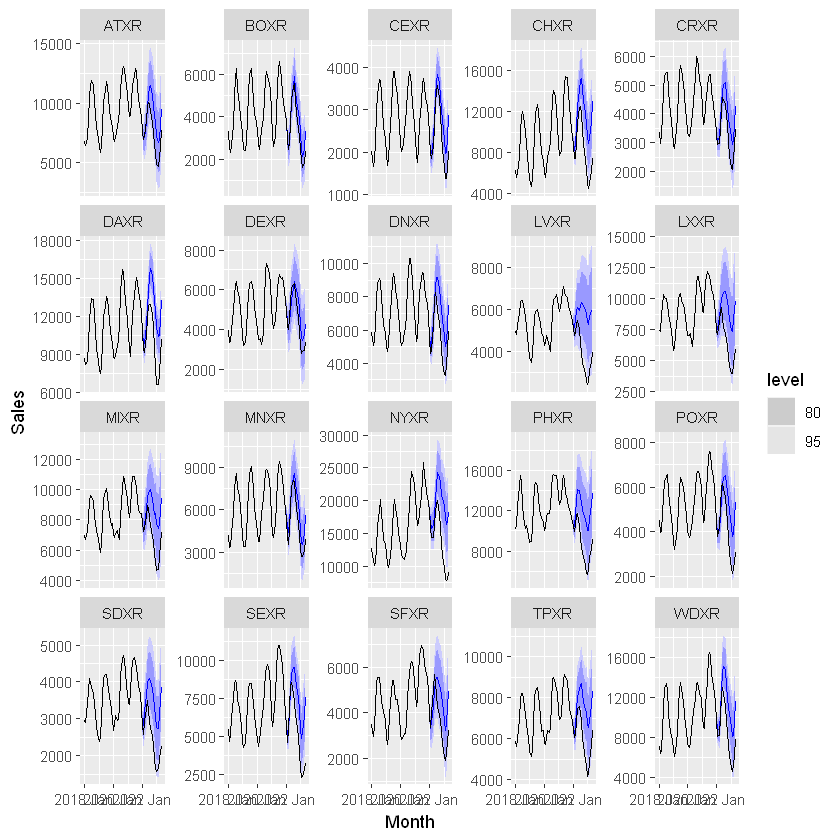

In [19]:
sp_forecasts %>%
filter(!is_aggregated(City), .model == 'MinT') %>%
autoplot(sales_ts %>% filter_index('2018 Jan' ~ .)) +
facet_wrap(vars(City), scales='free_y')

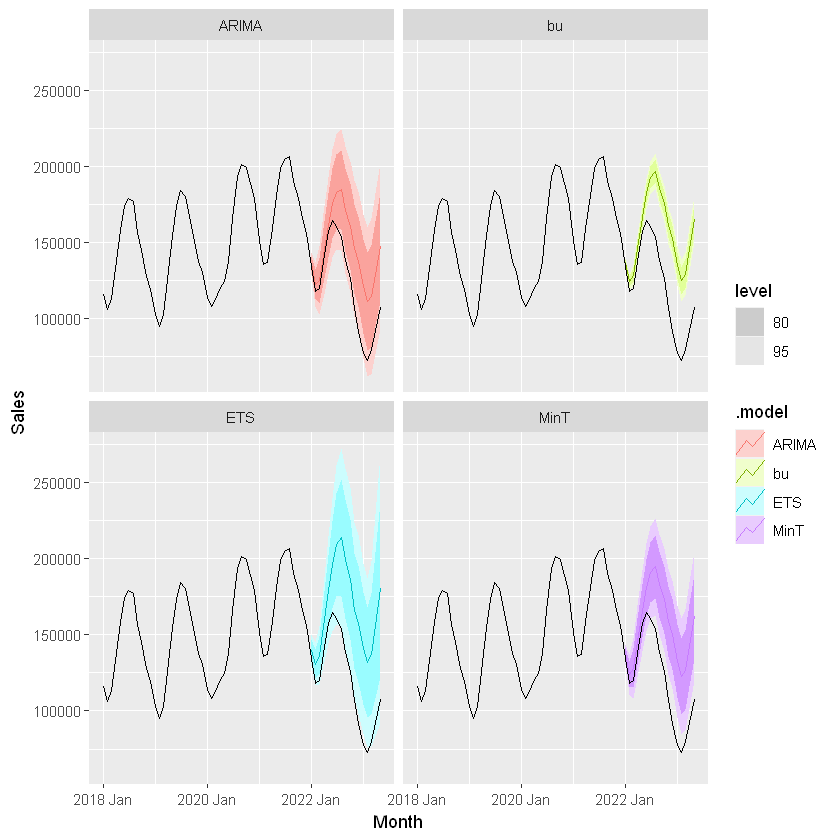

In [20]:
sp_forecasts %>%
filter(is_aggregated(City)) %>%
autoplot(sales_ts %>% filter_index('2018 Jan' ~ .)) +
facet_wrap(vars(.model))

#### Retrain for Out-of-Sample

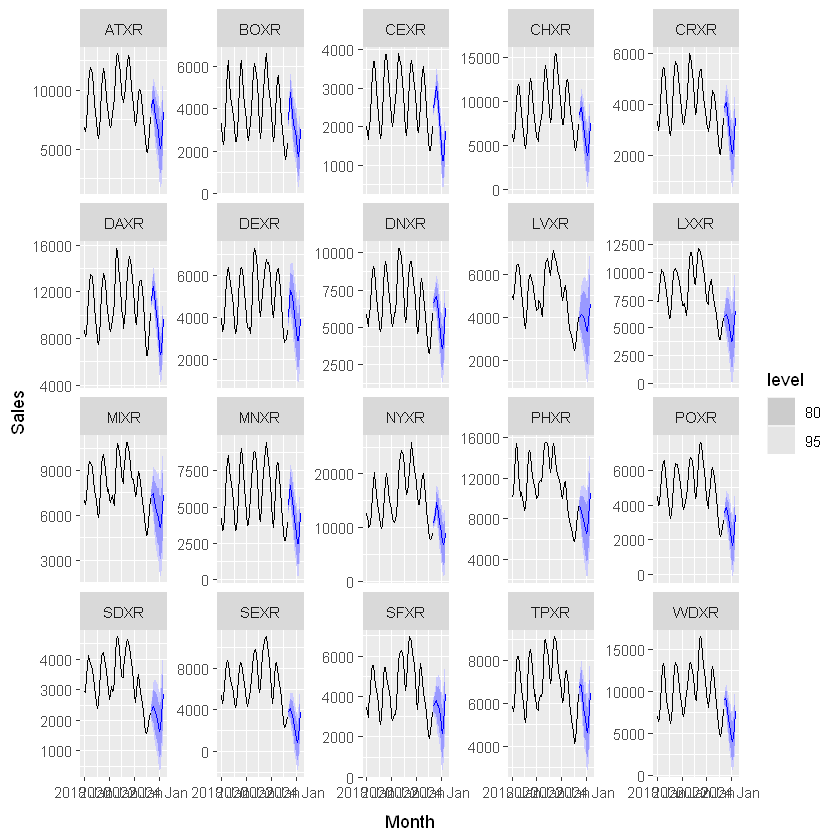

In [21]:
final_sales_model <- sales_ts %>%
model('ARIMA' = ARIMA(Sales)) %>%
reconcile(MinT = min_trace(ARIMA, method = "mint_shrink"))

final_sales_forecasts <- final_sales_model %>% forecast(h='12 months')

final_sales_forecasts %>%
filter(!is_aggregated(City), .model == 'MinT') %>%
autoplot(sales_ts %>% filter_index('2018 Jan' ~ .)) +
facet_wrap(vars(City), scales='free_y')

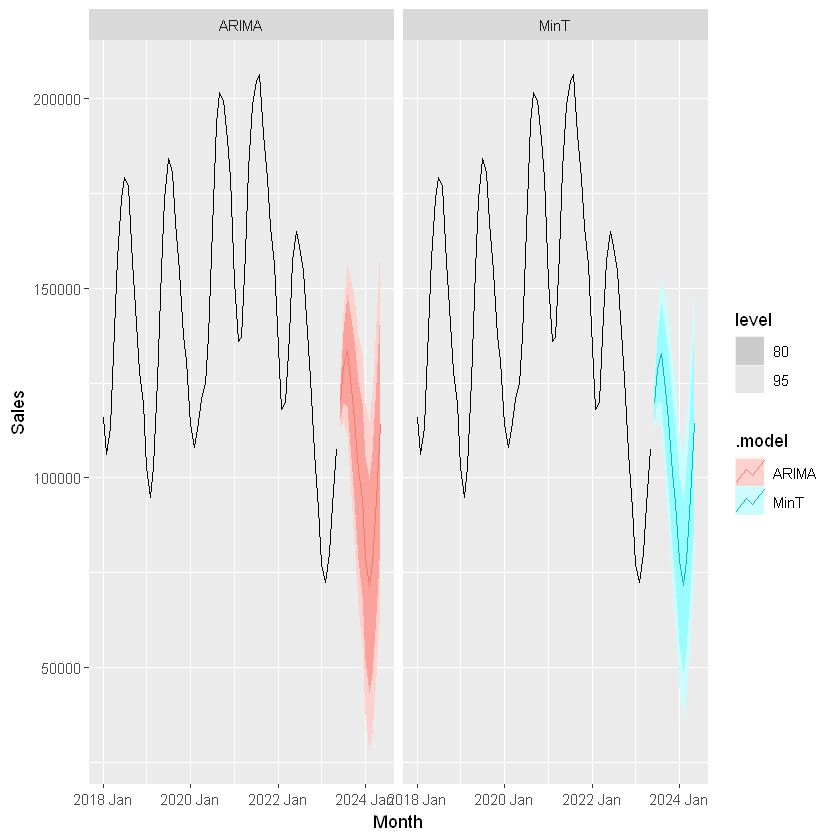

In [22]:
final_sales_forecasts %>%
filter(is_aggregated(City)) %>%
autoplot(sales_ts %>% filter_index('2018 Jan' ~ .)) +
facet_wrap(vars(.model), nrow=1)